In [59]:
import cv2
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import tqdm


In [2]:
# capture video
cap = cv2.VideoCapture('ripcurrent.mp4')

In [3]:

def framepairs(n=1000, s=None):
    """yield gray framepairs, by sliced by optional s"""
    if s is None:
        s = np.s_[:, :]
    status, img0 = cap.read()
    if not status == True:
        raise StopIteration()
    for i in range(n):
        status, img1 = cap.read()
        if not status == True:
            break
        gray0 = cv2.cvtColor(img0[s], cv2.COLOR_BGR2GRAY)
        gray1 = cv2.cvtColor(img1[s], cv2.COLOR_BGR2GRAY)
        yield gray0, gray1
        img0, img1 = img1, None

def warp_flow(img, flow):
    """apply a flow field to an image (from opt_flow.py in opencv)"""
    h, w = flow.shape[:2]
    flow = -flow
    flow[:, :, 0] += np.arange(w)
    flow[:, :, 1] += np.arange(h)[:, np.newaxis]
    res = cv2.remap(img, flow, None, cv2.INTER_LINEAR)
    return res        
        

In [4]:
# we just have few frames, store everything in memory
flows = []
grays = []
# slice in half 
for gray0, gray1 in framepairs(s=np.s_[::2, ::2]):
    # compute flow
    flow = cv2.calcOpticalFlowFarneback(gray0, gray1, None, 0.5, 5, 10, 3, 5, 1.1, 0)
    # keep
    flows.append(flow[np.newaxis, ...])
    # keep current image
    grays.append(gray0)
# convert to array
flows = np.concatenate(flows, axis=0)

In [ ]:
# loop over all flows to generate a warning image (rip lights up in red)
for i in range(flows.shape[0]):
    gray = grays[i]
    # compute average flow up to now
    UV = np.average(flows[:i], axis=0)
    # split 
    U, V = UV[..., 0], UV[..., 1]
    # convert and map to colors
    angle = np.mod(np.arctan2(V, U) + 0.1*np.pi, 2*np.pi)
    N_angle = matplotlib.colors.Normalize(0, 2*np.pi, clip=True)
    velocity = np.sqrt(U**2 + V**2)
    N_velocity = matplotlib.colors.Normalize(0, np.max(velocity), clip=True)
    v = N_velocity(velocity)
    hsv = np.dstack([N_angle(angle), np.zeros_like(angle) + float(i)/flows.shape[0], gray.astype('float32')/255])
    # convert back to rgb
    rgb = matplotlib.colors.hsv_to_rgb(hsv)
    # plot
    plt.imsave('rip_%06d.png' % (i, ), rgb)

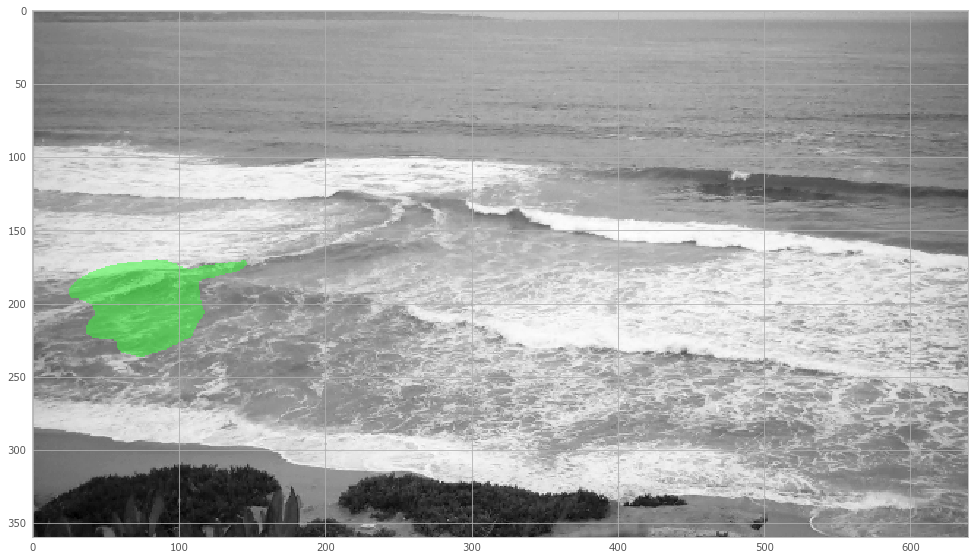

In [78]:
# generate a colormap with transparency
greens_alpha = matplotlib.colors.ListedColormap([[0.2,1,0.2,0.0], [0.2,1,0.2, 1.0]])

# generate a plot without too much whitespace
fig, ax = plt.subplots(figsize=(13, 8))
fig.tight_layout()
fig.subplots_adjust(left=0, bottom=0, right=1, top=1)
# ax.axis('off')

# initial paint
paint = np.zeros_like(gray0, dtype='uint8').copy()
cv2.circle(paint, (85, 200), 20, 255, -1)

# keep plot elements so we can update data
im_gray = ax.imshow(gray0, cmap='Greys_r')
im_paint = ax.imshow(paint, cmap=greens_alpha, alpha=0.5, vmax=255, vmin=0)
# progress
for i in tqdm.tqdm_notebook(range(len(flows))): # flows.shape[0]):
    UV = flows[i]
    # keep pooring in dye
    cv2.circle(paint, (85, 200), 30, 255, -1)
    # advect
    paint = warp_flow(paint, UV)
    # update
    im_gray.set_data(grays[i])
    im_paint.set_data(paint)
    # save (combine later with ffmpeg)
    fig.savefig('rip_%06d.png' % (i, ))